In [1]:
class year_selector:
    """ Enter the desired year to product a dataframe containing the results from the year.
    ISO_Code: Country Code, year_x: Primary School, year_y: Secondary School, year_x: GDP per Capita, year_y: Mortality Rate"""
    def __init__(self, chosen_year):
        self.year = chosen_year
        
    def mortality(self):
        import pandas as pd
        import numpy as np
#         CSV data
        primary = pd.read_csv('primary_school.csv')
        secondary_school = pd.read_csv('secondary_school.csv')
        gdp_csv = pd.read_csv('Global_GDP.csv')
        rates = pd.read_csv('mortality_rate.csv')
        
#     PRIMARY SCHOOLING DATA CLEANING
        primary_table = primary.iloc[:,2:]
        cols = list(primary_table.columns)
        cols = [cols[-1]] + cols[:-1]
        primary_table = primary_table[cols]
        primary_table = primary_table.rename(columns={"ISO-alpha3 code":"ISO_Code"})
        primary_table = primary_table[['ISO_Code',self.year]]
        primary_table = primary_table.replace({'..':np.NaN})
        primary_table = primary_table.dropna()
        primary_table = primary_table.rename(columns={primary_table.columns[1]:"Primary_School"})
        
# SECONDARY SCHOOLING DATA CLEANING
        secondary_table = secondary_school.iloc[:,2:]
        cols = list(secondary_table.columns)
        cols = [cols[-1]] + cols[:-1]
        secondary_table = secondary_table[cols]
        secondary_table = secondary_table.rename(columns={"ISO-alpha3 code":"ISO_Code"})
        secondary_table = secondary_table[['ISO_Code',self.year]]
        secondary_table = secondary_table.replace({'..':np.NaN})
        secondary_table = secondary_table.dropna()
        secondary_table = secondary_table.rename(columns={secondary_table.columns[1]:"Secondary_School"})

# GDP DATA CLEANING
        gdp_table = gdp_csv.rename(columns={'Country Code':'ISO_Code'})
        gdp_table = gdp_table[['ISO_Code',self.year]]
        gdp_table = gdp_table.rename(columns={gdp_table.columns[1]:"GDP_per_Capita"})

    
#     MORTALITY RATES DATA CLEANING
        codes = rates['ISO Code']
        counter = 0
        country_id = []
        for code in codes:
            if counter < 1:
                counter += 1
                country_id.append(code)
            elif counter < 2:
                counter += 1
            else:
                counter = 0  
        ids = pd.DataFrame(country_id)
        year = rates[self.year]
        averages = year.groupby(np.arange(len(year))//3).mean()
        year = pd.DataFrame(averages)
        rates_table = pd.concat([ids, year],axis=1)
        rates_table = rates_table.rename(columns={0:'ISO_Code'})
        rates_table = rates_table.rename(columns={rates_table.columns[1]:"Mortality_Rates"})


# MERGE ALL OF THE DATA TOGETHER 
        final_table = pd.merge(primary_table, secondary_table, on='ISO_Code', how='inner')
        final_table = pd.merge(final_table, gdp_table, on='ISO_Code', how='inner')
        final_table = pd.merge(final_table, rates_table, on='ISO_Code', how='inner')
        
#         DATA PRE-PROCESSING
        X = final_table.loc[:, ['Primary_School','Secondary_School','GDP_per_Capita']]
        y = final_table['Mortality_Rates'].values.reshape(-1,1)
#         print(X.shape,y.shape)

        # LOOK UP (, random_state=#)
        from sklearn.model_selection import train_test_split
        from sklearn.preprocessing import LabelEncoder, StandardScaler
        from keras.utils import to_categorical

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
        # insert test_size=... and train_size=... 
        X_scaler = StandardScaler().fit(X_train)
        y_scaler = StandardScaler().fit(y_train)
        # X_test_scaled = X_scaler.transform(X_test)

        # Transform the training and testing data using the X_scaler and y_scaler models
        X_train_scaled = X_scaler.transform(X_train)
        X_test_scaled = X_scaler.transform(X_test)
        y_train_scaled = y_scaler.transform(y_train)
        y_test_scaled = y_scaler.transform(y_test)
        
        from keras.models import Sequential
        from keras.layers import Dense

        model = Sequential()
        model.add(Dense(units=10, activation='relu', input_dim=3, kernel_initializer='random_uniform'))
        model.add(Dense(units=20, activation='relu'))
        model.add(Dense(units=1, activation='linear'))
        
        model.compile(optimizer='adam',
             loss = 'mean_squared_error',
             metrics=['acc'])

        model.fit(
            X_train_scaled, 
            y_train_scaled, 
            epochs=60, 
            shuffle=True, 
            verbose=2)
        
        model.summary()
        
        from sklearn.linear_model import LinearRegression
        model = LinearRegression()
        
        model.fit(X_train, y_train)
        training_score = model.score(X_train, y_train)
        testing_score = model.score(X_test, y_test)
        print(f"Training Score: {training_score}")
        print(f"Testing Score: {testing_score}")
        
#       RESIDUAL PLOT
        %matplotlib inline
        import matplotlib.pyplot as plt
        
        plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
        plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
        plt.legend()
        plt.hlines(y=0, xmin=y.min(), xmax=y.max())
        plt.title("Residual Plot")
        
#       MEAN SQUARED ERROR, R-SQUARED, AND PREDICTIONS
        from sklearn.metrics import mean_squared_error

        predictions = model.predict(X_test_scaled)
        MSE = mean_squared_error(y_test_scaled, predictions)
        r2 = model.score(X_test_scaled, y_test_scaled)

        print(f"MSE: {MSE}, R2: {r2}")
        print(predictions)


        return(final_table)

        
        


In [2]:
user = year_selector('2011')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


/Users/davidcdainko/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/davidcdainko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
/Users/davidcdainko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:88: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.


Instructions for updating:
Use tf.cast instead.
Epoch 1/60
 - 0s - loss: 1.0160 - acc: 0.0000e+00
Epoch 2/60
 - 0s - loss: 1.0091 - acc: 0.0000e+00
Epoch 3/60
 - 0s - loss: 1.0030 - acc: 0.0000e+00
Epoch 4/60
 - 0s - loss: 0.9975 - acc: 0.0000e+00
Epoch 5/60
 - 0s - loss: 0.9926 - acc: 0.0000e+00
Epoch 6/60
 - 0s - loss: 0.9884 - acc: 0.0000e+00
Epoch 7/60
 - 0s - loss: 0.9839 - acc: 0.0000e+00
Epoch 8/60
 - 0s - loss: 0.9796 - acc: 0.0000e+00
Epoch 9/60
 - 0s - loss: 0.9756 - acc: 0.0000e+00
Epoch 10/60
 - 0s - loss: 0.9717 - acc: 0.0000e+00
Epoch 11/60
 - 0s - loss: 0.9676 - acc: 0.0000e+00
Epoch 12/60
 - 0s - loss: 0.9638 - acc: 0.0000e+00
Epoch 13/60
 - 0s - loss: 0.9599 - acc: 0.0000e+00
Epoch 14/60
 - 0s - loss: 0.9560 - acc: 0.0000e+00
Epoch 15/60
 - 0s - loss: 0.9522 - acc: 0.0000e+00
Epoch 16/60
 - 0s - loss: 0.9476 - acc: 0.0000e+00
Epoch 17/60
 - 0s - loss: 0.9430 - acc: 0.0000e+00
Epoch 18/60
 - 0s - loss: 0.9382 - acc: 0.0000e+00
Epoch 19/60
 - 0s - loss: 0.9332 - acc: 0.0

,ISO_Code,Primary_School,Secondary_School,GDP_per_Capita,Mortality_Rates
0,ARM,4.23833,3.37278,3526.978143,17.266667
1,AZE,14.03457,6.11723,7189.691229,35.433333
2,BLR,9.0297,3.41588,6519.230195,5.100000
3,BEL,2.13122,3.46296,47743.780530,4.400000
4,BLZ,2.94798,2.78339,4515.892701,18.433333
5,BEN,10.38344,21.49202,825.942785,113.233333
6,BTN,11.38712,20.73967,2458.045976,40.433333
7,BOL,6.86173,23.36538,2377.688771,44.233333
8,BGR,0.25569,6.1468,7813.806692,10.300000
9,BFA,37.22081,13.69602,666.840410,109.733333


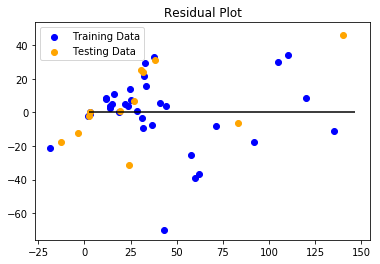

In [3]:
the_id = user.year
table = user.mortality()
table

In [569]:
# the_id = user.year
# table = user.mortality()
# table

In [4]:
class country_selector:
    """blah blah blah """
    def __init__(self, chosen_country):
        self.country = chosen_country
        
    def prediction_chart(self):
        import pandas as pd
        import numpy as np
        import math
        from sklearn import preprocessing
#         EXTRACT DATA FROM CSV'S
        primary_school = pd.read_csv('primary_school.csv')
#         secondary_school = pd.read_csv('secondary_school.csv')
        df_gdp = pd.read_csv('Global_GDP.csv')
        mortalities = pd.read_csv('mortality_rate.csv')
        
#         FILTER FOR THE SELECTED COUNTRY
        selected_primary = primary_school.loc[primary_school['Country']==self.country]
#         selected_secondary = secondary_school.loc[secondary_school['Country']==self.country]
        selected_gdp = df_gdp.loc[df_gdp['Country Name']==self.country]
        selected_mortalities = mortalities.loc[mortalities['Country Name']==self.country]
        
#         CLEAN THE DATA:
# PRIMARY
        selected_primary = selected_primary.iloc[:,2:-1]
        selected_primary = selected_primary.transpose()
        selected_primary = selected_primary.rename(columns={selected_primary.columns[0]:"Primary_School"})

# SECONDARY
#         selected_secondary = selected_secondary.iloc[:,2:-1]
#         selected_secondary = selected_secondary.transpose()
#         selected_secondary = selected_secondary.rename(columns={selected_secondary.columns[0]:"Secondary_School"})

# GDP
        selected_gdp = selected_gdp.iloc[:,3:]
        selected_gdp = selected_gdp.transpose()
        selected_gdp = selected_gdp.rename(columns={selected_gdp.columns[0]:"GDP_per_Capita"})

# MORTALITIES
        codes = selected_mortalities['ISO Code']
        counter = 0
        country_id = []
        for code in codes:
            if counter < 1:
                counter += 1
                country_id.append(code)
            elif counter < 2:
                counter += 1
            else:
                counter = 0
        country_id = pd.DataFrame(country_id)
        avg_mortalities = selected_mortalities.groupby(np.arange(len(selected_mortalities))//3).mean()
        selected_mortalities = pd.concat([country_id, avg_mortalities],axis=1)
        selected_mortalities = selected_mortalities.iloc[:,1:]
        selected_mortalities = selected_mortalities.transpose()
        selected_mortalities = selected_mortalities.rename(columns={selected_mortalities.columns[0]:"Mortality_Rate"})
        
#         JOIN THE TABLES
#         joined_table = selected_primary.join(selected_secondary, how='inner')
        joined_table = selected_primary.join(selected_gdp, how='inner')
        joined_table = joined_table.join(selected_mortalities, how='inner')
        joined_table = joined_table.replace({'..':np.NaN})
        joined_table = joined_table.dropna()
        
#         CREATE PREDICTIVE CHART
        forecast_out = int(math.ceil(0.1*len(joined_table)))
        forecast_col = 'Mortality_Rate'
        joined_table['label'] = joined_table[forecast_col].shift(-forecast_out)
        
        X = np.array(joined_table.drop(['label'],1))
        X = preprocessing.scale(X)
        X = X[:-forecast_out]
        X_lately = X[-forecast_out:]
        joined_table.dropna(inplace=True)
        y = np.array(joined_table['label'])
        y = np.array(joined_table['label'])
        
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LinearRegression
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        clf = LinearRegression(n_jobs=-1)
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)
        
        forecast_set = clf.predict(X_lately)
    
        import datetime as datetime
        import matplotlib.pyplot as plt
        from matplotlib import style
        import time
        style.use('ggplot')
        
        joined_table["Forecast"] = np.NaN
        
        last_date = joined_table.iloc[-1].name
        last_unix = time.mktime(datetime.datetime.strptime(last_date, '%Y').timetuple())
        one_year = 31536000
        next_unix = last_unix + one_year
        
        for i in forecast_set:
            next_year = datetime.datetime.fromtimestamp(next_unix)
            next_unix += one_year
            next_year = next_year.year
            joined_table.loc[next_year] = [np.NaN for _ in range(len(joined_table.columns)-1)] + [i]
            
        joined_table['Mortality_Rate'].plot()
        joined_table['Forecast'].plot()
        plt.legend(loc=3)
        plt.xlabel('Year')
        plt.ylabel('Mortality Rate')
        plt.show()





        
        return(joined_table, forecast_set, accuracy, forecast_out)

In [5]:
user = country_selector('Ireland')

/Users/davidcdainko/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


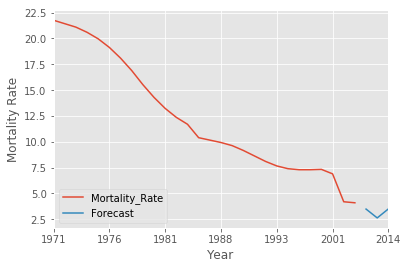

(     Primary_School  GDP_per_Capita  Mortality_Rate      label  Forecast
 1971        4.59363     1705.972661       21.766667  19.966667       NaN
 1972        6.02848     2082.956898       21.433333  19.133333       NaN
 1973        5.79329     2427.172361       21.100000  18.100000       NaN
 1974        6.44096     2519.941754       20.600000  16.900000       NaN
 1975        5.61503     2976.961022       19.966667  15.533333       NaN
 1976        4.61964     2923.079756       19.133333  14.300000       NaN
 1977        3.90134     3431.177594       18.100000  13.233333       NaN
 1978        3.47226     4405.256228       16.900000  12.366667       NaN
 1979        4.42332     5436.465018       15.533333  11.700000       NaN
 1980         6.2486     6380.069668       14.300000  10.400000       NaN
 1981        8.87999     5993.323120       13.233333  10.166667       NaN
 1982       11.63434     6168.016540       12.366667   9.933333       NaN
 1983       13.48394     5922.326009  

In [6]:
the_id = user.country
table = user.prediction_chart()
table

In [ ]:
        from sklearn.metrics import mean_squared_error
        import matplotlib.pyplot as plt
        from keras.models import Sequential
        from keras.layers import Dense
        from sklearn.model_selection import train_test_split
        from sklearn.preprocessing import LabelEncoder, StandardScaler
        from keras.utils import to_categorical
        import datetime as datetime
        import matplotlib.pyplot as plt
        from matplotlib import style
        import time
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LinearRegression
        import pandas as pd
        import numpy as np
        import math
        from sklearn import preprocessing